In [1]:
import pandas as pd
import requests
from io import BytesIO
from typing import List

def load_and_merge_csv_xz_from_github(years: List[int], companies: List[str], base_url: str) -> pd.DataFrame:
    all_dataframes = []
    
    for year in years:
        for company in companies:
            filename = f"df_{year}_{company}.csv.xz"
            file_url = f"{base_url}/{filename}"
            
            response = requests.get(file_url)
            if response.status_code == 200:
                file_content = BytesIO(response.content)
                df = pd.read_csv(file_content, compression='xz')
                all_dataframes.append(df)

    merged_dataframe = pd.concat(all_dataframes, ignore_index=True)

    # Sort dataframe by date
    df_sorted = merged_dataframe.sort_values(by='post_date')

    # Remove the 'Unnamed: 0' column
    df_sorted = df_sorted.drop(columns=['Unnamed: 0'])
    
    # Drop 'year' columns that was used previously to split dataframes and save them as smaller csv files 
    df_sorted = df_sorted.drop(columns=['year'])


    # Reset the index of the dataframe and drop the old one
    df_sorted = df_sorted.reset_index(drop=True)

    return df_sorted

    
base_url = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data"
years = [2015, 2016, 2017, 2018, 2019]
companies = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'GOOG', 'MSFT']
tweets_df = load_and_merge_csv_xz_from_github(years, companies, base_url)



In [4]:
tweets_df.dtypes

ticker_symbol    object
company_name     object
tweet_id          int64
writer           object
post_date        object
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object

In [2]:
tweets_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,AAPL,apple,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
2,AMZN,Amazon.com,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,TSLA,Tesla Inc,550443808606126081,aaplstocknews,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [12]:
import pandas as pd
import re

def filter_tweets(df):
    df = df.copy()

    print("Initial dataset length:", len(df))

    # Normalize URLs in the tweet bodies - replace with "URL" or remove
    df['body'] = df['body'].apply(lambda text: re.sub(r'http\S+', 'URL', text))

    # Remove all duplicates based on 'tweet_id' and 'ticker_symbol' (possibly collection errors)
    df.drop_duplicates(subset=['tweet_id', 'ticker_symbol'], inplace=True, keep = 'first')
    print("After removing duplicate tweet_ids and ticker_symbols:", len(df))

    # Remove last duplicates based on 'tweet_id' and 'company_name'(will only apply to Google as they have different ticker_symbols)
    df.drop_duplicates(subset=['tweet_id', 'company_name'], inplace=True, keep = 'first')
    print("After removing duplicate tweet_ids and company_names (Google):", len(df))

    # Introduce new common ticker symbol for google
    df['ticker_symbol'] = df['ticker_symbol'].replace({'GOOG': 'GOOGLE', 'GOOGL': 'GOOGLE'})

    # Remove tweets with duplicate texts longer than 5 words considering the ticker symbol
    df['word_count'] = df['body'].apply(lambda text: len(text.split()))
    duplicates = df[(df['word_count'] > 5)].duplicated(subset=['body', 'ticker_symbol'], keep=False)
    df = df.loc[~df.index.isin(duplicates[duplicates].index)]
    print("After removing tweets duplicate texts longer than 5 words:", len(df))

    # Apply counting functions
    df['hashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('#')))
    df['cashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('$')))
    df['mention_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('@')))

    # Filter tweets based on hashtag and cashtag counts
    df = df[(df['cashtag_count'] < 5) & (df['hashtag_count'] < 8)]
    print("After filtering by cashtags and hashtags:", len(df))

    # Ratio filters (cashtags, hashtags, mentions to words)
    df['cashtag_ratio'] = df['cashtag_count'] / df['word_count'].replace(0, 1)
    df['hashtag_ratio'] = df['hashtag_count'] / df['word_count'].replace(0, 1)
    df['mention_ratio'] = df['mention_count'] / df['word_count'].replace(0, 1)
    df = df[(df['cashtag_ratio'] <= 0.5) & (df['hashtag_ratio'] <= 0.5) & (df['mention_ratio'] <= 0.5)]
    print("After filtering by ratios:", len(df))

    # Keyword filter (defined by Wilksch, Abramova (2023) PyFin-sentiment: Towards a machine-learning-based model for deriving sentiment from financial tweets)
    keywords = ['bitcoin', 'etherium', 'btc', 'eth', 'nft', 'token', 'wallet', 'web3',
                'airdrop', 'wagmi', 'solana', 'opensea', 'cryptopunks', 'uniswap', 
                'lunar', 'hodl', 'binance', 'coinbase', 'cryptocom', 'doge']
    df['keyword_count'] = df['body'].apply(lambda text: sum(text.lower().count(kw) for kw in keywords))
    df = df[df['keyword_count'] <= 2]
    print("After filtering by keyword count:", len(df))

    df = df.reset_index(drop=True)

    return df


In [13]:
filtered_df = filter_tweets(tweets_df)


Initial dataset length: 4336445
After removing duplicate tweet_ids and ticker_symbols: 4336445
After removing duplicate tweet_ids and company_names (Google): 4288706
After removing tweets duplicate texts longer than 5 words: 3192655
After filtering by cashtags and hashtags: 2526934
After filtering by ratios: 2506779
After filtering by keyword count: 2506058


In [14]:
import pandas as pd

def check_empty_bodies(df):
    # Check for empty or NaN entries in the 'body' column
    empty_bodies = df['body'].isna() | (df['body'] == '')
    
    # Count the number of empty or NaN entries
    empty_count = empty_bodies.sum()
    
    # Print the results
    if empty_count > 0:
        print(f"There are {empty_count} empty 'body' cells in the DataFrame.")
    else:
        print("There are no empty 'body' cells in the DataFrame.")

    # Optionally, you might want to return a DataFrame with the empty entries for review
    empty_entries = df[empty_bodies]
    return empty_entries


In [15]:
# Check processed data frame for missing text values
empty_entries = check_empty_bodies(filtered_df)
if not empty_entries.empty:
    print("Empty entries found:", empty_entries)

There are no empty 'body' cells in the DataFrame.


In [18]:
import datetime
import pytz

# convert post_date back to int64

# convert from object to datetime
filtered_df['post_date'] = pd.to_datetime(filtered_df['post_date'])

# convert to int64
filtered_df['date_int'] = filtered_df['post_date'].apply(lambda x: int(x.timestamp()))

def convert_utc_to_ny(timestamp):
    # Define the UTC timezone
    utc_timezone = pytz.timezone('UTC')
    
    # Define the New York timezone
    ny_timezone = pytz.timezone('America/New_York')
    
    # Create a timezone-aware datetime object in UTC directly from the Unix timestamp
    utc_aware_datetime = datetime.datetime.fromtimestamp(timestamp, utc_timezone)
    
    # Convert the datetime object from UTC to New York Time
    ny_datetime = utc_aware_datetime.astimezone(ny_timezone)

    # # Format New York datetime to a string without timezone information
    # formatted_new_york_datetime = new_york_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    # return formatted_new_york_datetime
    
    return ny_datetime

# Example usage
# timestamp = 1420070457
# print(convert_utc_to_ny(timestamp))

# The example usage is commented out to adhere to instructions of not executing the code here.


In [19]:
filtered_df['date_new_york'] = filtered_df['date_int'].apply(convert_utc_to_ny)

<Axes: xlabel='hour'>

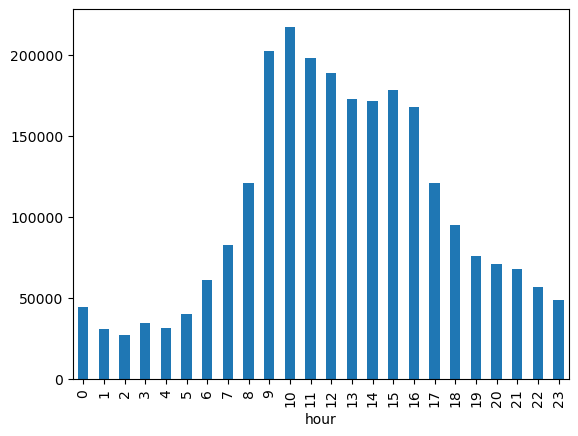

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a 'date_new_york' column

# Extracting the hour from 'date_new_york' and creating a new column 'hour'
filtered_df['hour'] = filtered_df['date_new_york'].dt.hour

# Group by the new 'hour' column and calculate the mean number of tweets per hour
# average_tweets_per_hour = filtered_df.groupby('hour').count().mean()

filtered_df.groupby('hour').size().plot(kind='bar')


In [33]:
filtered_df = filtered_df.rename(columns={'post_date': 'date_utc'}).drop(columns=['date_int'])

In [35]:
filtered_df.head()

,ticker_symbol,company_name,tweet_id,writer,date_utc,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,hour
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,2014-12-31 19:01:36-05:00,19
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,2014-12-31 19:06:47-05:00,19
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,0,0,1,12,0,1,1,0.083333,0.0,0.083333,1,2014-12-31 19:14:42-05:00,19
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,“@WSJ: Apple is being sued for falsely adverti...,0,0,0,15,0,1,0,0.066667,0.0,0.000000,0,2014-12-31 19:14:42-05:00,19
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,Apple filed for its own stylus patent in 2010 ...,0,0,0,11,0,1,0,0.090909,0.0,0.000000,0,2014-12-31 19:15:05-05:00,19


In [36]:
# check if data set contains emojis

# pip install emoji
import emoji

def contains_emoji(text):
    return emoji.emoji_count(text) > 0


filtered_df['has_emoji'] = filtered_df['body'].apply(contains_emoji)

any_emojis = filtered_df['has_emoji'].any()
print("Is there at least one emoji in the text body column?", any_emojis)




Is there at least one emoji in the text body column? True


In [37]:
import re
import emoji

def preprocess_text_column(df):
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Escape regex special characters and join them to form a regex pattern
    punctuation_marks = [',', '.', '?', '!', '*', ':', ';', '”', 
                         '“', '"', "’", "’", "%", "&", "'", "(",
                         ")", "-", '``', "''"]
    escaped_punctuation = [re.escape(char) for char in punctuation_marks]
    punctuation_pattern = f"[{''.join(escaped_punctuation)}]"

    def transform_text(text):
        # Replace emojis with a space
        text = emoji.replace_emoji(text, replace=' ')
        
        # Convert to lowercase
        text = text.lower()

        # Replace newlines with spaces
        text = text.replace('\n', ' ')

        # Remove repeated characters more than twice
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        
        # Remove specific punctuation
        text = re.sub(punctuation_pattern, '', text)

        # Strip and replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text

    # Apply the transformation to the 'body' column
    df['body'] = df['body'].apply(transform_text)
    
    return df

# Example usage:
# import pandas as pd
# df = pd.DataFrame({'body': ['Long money game. ♟                            We hope Jackboys has some Tesla stocks since their adding hype to $TSLA brand.']})
# print(preprocess_text_column(df))


In [38]:
# Preprocess text column
preprocessed_df = preprocess_text_column(filtered_df)

In [39]:
preprocessed_df['has_emoji_pp'] = preprocessed_df['body'].apply(contains_emoji)

any_emojis_pp = preprocessed_df['has_emoji_pp'].any()
print("Is there at least one emoji in the text body column?", any_emojis_pp)

Is there at least one emoji in the text body column? False


In [40]:
preprocessed_df = preprocessed_df.drop(columns=['has_emoji', 'has_emoji_pp'])

In [41]:
preprocessed_df.head()

,ticker_symbol,company_name,tweet_id,writer,date_utc,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,hour
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,2014-12-31 19:01:36-05:00,19
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,2014-12-31 19:06:47-05:00,19
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,0,1,1,0.083333,0.0,0.083333,1,2014-12-31 19:14:42-05:00,19
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,0,1,0,0.066667,0.0,0.000000,0,2014-12-31 19:14:42-05:00,19
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,0,1,0,0.090909,0.0,0.000000,0,2014-12-31 19:15:05-05:00,19


In [42]:
from pyfin_sentiment.model import SentimentModel
import numpy as np
import pandas as pd  # Ensure pandas is imported if not already

# Initialize the sentiment model
model = SentimentModel("small")

def apply_batch_sentiment(texts, batch_size=1000):
    # Initialize lists to store sentiment results and probabilities
    sentiments = []
    probabilities = []
    
    # Process texts in batches
    total_texts = len(texts)
    for i in range(0, total_texts, batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Get predictions and probabilities
        batch_predictions = model.predict(batch_texts)
        batch_probabilities = model.predict_proba(batch_texts)
        
        sentiments.extend(batch_predictions)
        probabilities.extend(batch_probabilities)
        
        # Print progress
        processed = min(i + batch_size, total_texts)
        print(f"Processed {processed}/{total_texts} texts")
    
    return sentiments, probabilities


/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression

In [43]:
# Apply sentiment analysis in batches to the 'body' column
sentiment_df = preprocessed_df.copy()

results = apply_batch_sentiment(sentiment_df['body'].tolist(), batch_size=1000)
sentiment_df['sentiment'] = results[0]
sentiment_df['sentiment_probability'] = results[1]

Processed 1000/2506058 texts
Processed 2000/2506058 texts
Processed 3000/2506058 texts
Processed 4000/2506058 texts
Processed 5000/2506058 texts
Processed 6000/2506058 texts
Processed 7000/2506058 texts
Processed 8000/2506058 texts
Processed 9000/2506058 texts
Processed 10000/2506058 texts
Processed 11000/2506058 texts
Processed 12000/2506058 texts
Processed 13000/2506058 texts
Processed 14000/2506058 texts
Processed 15000/2506058 texts
Processed 16000/2506058 texts
Processed 17000/2506058 texts
Processed 18000/2506058 texts
Processed 19000/2506058 texts
Processed 20000/2506058 texts
Processed 21000/2506058 texts
Processed 22000/2506058 texts
Processed 23000/2506058 texts
Processed 24000/2506058 texts
Processed 25000/2506058 texts
Processed 26000/2506058 texts
Processed 27000/2506058 texts
Processed 28000/2506058 texts
Processed 29000/2506058 texts
Processed 30000/2506058 texts
Processed 31000/2506058 texts
Processed 32000/2506058 texts
Processed 33000/2506058 texts
Processed 34000/250

In [44]:
sentiment_df.head()

,ticker_symbol,company_name,tweet_id,writer,date_utc,body,comment_num,retweet_num,like_num,word_count,...,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,hour,sentiment,sentiment_probability
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,...,1,0,0.050000,0.0,0.000000,0,2014-12-31 19:01:36-05:00,19,3,"[0.2874074315094731, 0.23019124368310678, 0.48..."
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,...,2,2,0.153846,0.0,0.153846,0,2014-12-31 19:06:47-05:00,19,1,"[0.6947310550372033, 0.24863109754717022, 0.05..."
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,...,1,1,0.083333,0.0,0.083333,1,2014-12-31 19:14:42-05:00,19,2,"[0.408449110584451, 0.42334809219510977, 0.168..."
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,...,1,0,0.066667,0.0,0.000000,0,2014-12-31 19:14:42-05:00,19,3,"[0.29036728717008936, 0.3391678624867592, 0.37..."
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,...,1,0,0.090909,0.0,0.000000,0,2014-12-31 19:15:05-05:00,19,1,"[0.5134419420397436, 0.24901102379967055, 0.23..."


In [45]:
# Replace sentiment values so we can compute their average

# Convert the 'sentiment' column to integer
sentiment_df['sentiment'] = sentiment_df['sentiment'].astype(int)

# Define the mapping of old values to new values
replacement_map = {2: 0, 3: -1}

# Replace the values in the 'sentiment' column
sentiment_df['sentiment'] = sentiment_df['sentiment'].replace(replacement_map)

sentiment_df.head(n=2)

,ticker_symbol,company_name,tweet_id,writer,date_utc,body,comment_num,retweet_num,like_num,word_count,...,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,hour,sentiment,sentiment_probability
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,...,1,0,0.050000,0.0,0.000000,0,2014-12-31 19:01:36-05:00,19,-1,"[0.2874074315094731, 0.23019124368310678, 0.48..."
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,...,2,2,0.153846,0.0,0.153846,0,2014-12-31 19:06:47-05:00,19,1,"[0.6947310550372033, 0.24863109754717022, 0.05..."


In [46]:
# Add column which calculates sentiment score as weighted sum of the probabilites
sentiment_df['sentiment_prob_sum'] = sentiment_df['sentiment_probability'].apply(lambda p: 1 * p[0] + 0 * p[1] + -1 * p[2])

In [47]:
# Convert date columns into date_only
sentiment_df['date_only_NY'] = sentiment_df['date_new_york'].dt.date


In [48]:
sentiment_df.head()

,ticker_symbol,company_name,tweet_id,writer,date_utc,body,comment_num,retweet_num,like_num,word_count,...,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,hour,sentiment,sentiment_probability,sentiment_prob_sum,date_only_NY
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,...,0.050000,0.0,0.000000,0,2014-12-31 19:01:36-05:00,19,-1,"[0.2874074315094731, 0.23019124368310678, 0.48...",-0.194994,2014-12-31
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,...,0.153846,0.0,0.153846,0,2014-12-31 19:06:47-05:00,19,1,"[0.6947310550372033, 0.24863109754717022, 0.05...",0.638093,2014-12-31
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,...,0.083333,0.0,0.083333,1,2014-12-31 19:14:42-05:00,19,0,"[0.408449110584451, 0.42334809219510977, 0.168...",0.240246,2014-12-31
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,...,0.066667,0.0,0.000000,0,2014-12-31 19:14:42-05:00,19,-1,"[0.29036728717008936, 0.3391678624867592, 0.37...",-0.080098,2014-12-31
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,...,0.090909,0.0,0.000000,0,2014-12-31 19:15:05-05:00,19,1,"[0.5134419420397436, 0.24901102379967055, 0.23...",0.275895,2014-12-31


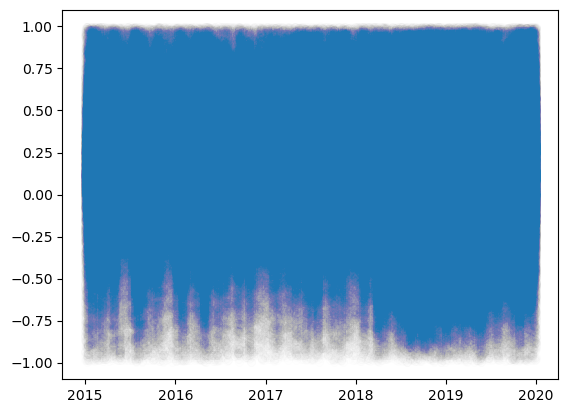

In [49]:
plt.scatter(sentiment_df['date_only_NY'], sentiment_df['sentiment_prob_sum'], alpha=0.005)


## Calculate unweighted sentiment score per day

With the information available in our dataset, we can't set the like, comment, or retweet numbers in relation to the number of views of the tweet or the author's number of followers! Therefore, weighting the sentiment scores could falsely skew resulting index!

In [50]:
unweighted_sentiment_df = sentiment_df.groupby(['date_only_NY', 'company_name'])['sentiment_prob_sum'].mean().reset_index()
unweighted_sentiment_df.columns = ['date_NY', 'company_name', 'unweighted_sentiment_score']

In [51]:
unweighted_sentiment_df.head()

,date_NY,company_name,unweighted_sentiment_score
0,2014-12-31,Amazon.com,-0.080420
1,2014-12-31,Google Inc,0.331881
2,2014-12-31,Microsoft,0.205846
3,2014-12-31,Tesla Inc,0.486267
4,2014-12-31,apple,0.187505


# Load market cap data

In [52]:
# Load market cap file

market_cap_path = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/market_cap/total_market_cap_2015-2019.xlsx"

market_cap_df = pd.read_excel(market_cap_path).sort_values("date").reset_index(drop=True)

market_cap_df['date'] = pd.to_datetime(market_cap_df['date'])

market_cap_df['weights_abs'] = market_cap_df['weights_abs'].astype(int)

market_cap_df['weights_rel'] = market_cap_df.groupby('date')['weights_abs'].transform(lambda x: x / x.sum())

# replace company ticker by company name for a smooth join

replacements = {"AAPL.O": "apple", "AMZN.O": "Amazon.com", "GOOG.O": "Google Inc", "MSFT.O": "Microsoft", "TSLA.O": "Tesla Inc"}

market_cap_df['company_ticker'] = market_cap_df['company_ticker'].replace(replacements)

market_cap_df.rename(columns={'company_ticker': 'company_name'}, inplace=True)



In [53]:
market_cap_df.head(n=10)

,company_name,date,weekday,market_cap,weights_abs,weights_rel
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972
1,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592
2,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381
3,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977
4,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078
5,Google Inc,2015-01-05,0,3.504869e+11,370020000000,0.224381
6,Amazon.com,2015-01-05,0,1.405184e+11,156790000000,0.095078
7,Tesla Inc,2015-01-05,0,2.634146e+10,30660000000,0.018592
8,apple,2015-01-05,0,6.231392e+11,697510000000,0.422972
9,Microsoft,2015-01-05,0,3.818502e+11,394090000000,0.238977


In [54]:
# Fill in values for non-workdays

import pandas as pd
import numpy as np

# # Example DataFrame creation
# data = {
#     'company_name': ['Company A', 'Company A', 'Company B', 'Company B'],
#     'date': ['2015-01-01', '2015-01-02', '2015-01-01', '2015-01-02'],
#     'weekday': ['Thursday', 'Friday', 'Thursday', 'Friday'],
#     'market_cap': [100, 105, 200, 210],
#     'weights_abs': [10, 10.5, 20, 21],
#     'weights_rel': [0.1, 0.105, 0.2, 0.21]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# Convert 'date' column to datetime
market_cap_df['date'] = pd.to_datetime(market_cap_df['date'])

# Create copy to not overwrite market_cap_df
market_cap_copy = market_cap_df.copy()

# Set the 'date' as index
market_cap_copy.set_index('date', inplace=True)

# Creating a full date range from 2015-01-01 to 2015-01-04 (for this example)
all_dates = pd.date_range(start='2015-01-01', end='2019-12-31')

# Reindexing DataFrame to the new date range for each company
market_cap_full_df = market_cap_copy.groupby('company_name').apply(lambda x: x.reindex(all_dates).ffill()).reset_index(level=0, drop=True)

# Fix the 'weekday' column to reflect the correct day of the week
market_cap_full_df['weekday'] = market_cap_full_df.index.day_name()

# Reset the index to convert 'date' from index to a regular column and reindex with default integer indexing
market_cap_full_df = market_cap_full_df.reset_index().rename(columns={'index': 'date'})


In [55]:
market_cap_full_df.head()

,date,company_name,weekday,market_cap,weights_abs,weights_rel
0,2015-01-01,NaN,Thursday,NaN,NaN,NaN
1,2015-01-02,Amazon.com,Friday,1.434618e+11,1.567900e+11,0.095078
2,2015-01-03,Amazon.com,Saturday,1.434618e+11,1.567900e+11,0.095078
3,2015-01-04,Amazon.com,Sunday,1.434618e+11,1.567900e+11,0.095078
4,2015-01-05,Amazon.com,Monday,1.405184e+11,1.567900e+11,0.095078


In [56]:
# Fill 2015-01-01 with values from 2015-01-02
jan_01_2015_data = np.array(market_cap_full_df[market_cap_full_df['date']=="2015-01-01"].index)

In [57]:
# for idx in jan_01_2015_data:
#     market_cap_full_df['company_name'][idx] = market_cap_full_df['company_name'][idx+1]
#     market_cap_full_df['market_cap'][idx] = market_cap_full_df['market_cap'][idx+1]
#     market_cap_full_df['weights_abs'][idx] = market_cap_full_df['weights_abs'][idx+1]
#     market_cap_full_df['weights_rel'][idx] = market_cap_full_df['weights_rel'][idx+1]


for idx in jan_01_2015_data:
    market_cap_full_df.loc[idx, 'company_name'] = market_cap_full_df.loc[idx+1, 'company_name']
    market_cap_full_df.loc[idx, 'market_cap'] = market_cap_full_df.loc[idx+1, 'market_cap']
    market_cap_full_df.loc[idx, 'weights_abs'] = market_cap_full_df.loc[idx+1, 'weights_abs']
    market_cap_full_df.loc[idx, 'weights_rel'] = market_cap_full_df.loc[idx+1, 'weights_rel']

In [58]:
market_cap_full_df[(market_cap_full_df['date']=="2015-01-01") | (market_cap_full_df['date']=="2015-01-02")]

,date,company_name,weekday,market_cap,weights_abs,weights_rel
0,2015-01-01,Amazon.com,Thursday,1.434618e+11,1.567900e+11,0.095078
1,2015-01-02,Amazon.com,Friday,1.434618e+11,1.567900e+11,0.095078
1826,2015-01-01,Google Inc,Thursday,3.576201e+11,3.700200e+11,0.224381
1827,2015-01-02,Google Inc,Friday,3.576201e+11,3.700200e+11,0.224381
3652,2015-01-01,Microsoft,Thursday,3.854358e+11,3.940900e+11,0.238977
3653,2015-01-02,Microsoft,Friday,3.854358e+11,3.940900e+11,0.238977
5478,2015-01-01,Tesla Inc,Thursday,2.749748e+10,3.066000e+10,0.018592
5479,2015-01-02,Tesla Inc,Friday,2.749748e+10,3.066000e+10,0.018592
7304,2015-01-01,apple,Thursday,6.412030e+11,6.975100e+11,0.422972
7305,2015-01-02,apple,Friday,6.412030e+11,6.975100e+11,0.422972


In [59]:
market_cap_full_sorted_df = market_cap_full_df.sort_values(by='date').reset_index(drop=True)
market_cap_full_sorted_df.head(n=10)

,date,company_name,weekday,market_cap,weights_abs,weights_rel
0,2015-01-01,Amazon.com,Thursday,1.434618e+11,1.567900e+11,0.095078
1,2015-01-01,apple,Thursday,6.412030e+11,6.975100e+11,0.422972
2,2015-01-01,Google Inc,Thursday,3.576201e+11,3.700200e+11,0.224381
3,2015-01-01,Microsoft,Thursday,3.854358e+11,3.940900e+11,0.238977
4,2015-01-01,Tesla Inc,Thursday,2.749748e+10,3.066000e+10,0.018592
5,2015-01-02,Amazon.com,Friday,1.434618e+11,1.567900e+11,0.095078
6,2015-01-02,apple,Friday,6.412030e+11,6.975100e+11,0.422972
7,2015-01-02,Google Inc,Friday,3.576201e+11,3.700200e+11,0.224381
8,2015-01-02,Microsoft,Friday,3.854358e+11,3.940900e+11,0.238977
9,2015-01-02,Tesla Inc,Friday,2.749748e+10,3.066000e+10,0.018592


In [60]:
# before joining, adapt column names of unweighted_sentiment_df
unweighted_sentiment_df.rename(columns={'date_NY': 'date'}, inplace=True)
unweighted_sentiment_df['date'] = pd.to_datetime(unweighted_sentiment_df['date'])

# join market_cap_df and unweighted_sentiment_df
unweighted_sentiment_market_cap_df = pd.merge(market_cap_full_sorted_df, unweighted_sentiment_df, on=['date', 'company_name'])

In [61]:
unweighted_sentiment_market_cap_df.head()

,date,company_name,weekday,market_cap,weights_abs,weights_rel,unweighted_sentiment_score
0,2015-01-01,Amazon.com,Thursday,1.434618e+11,1.567900e+11,0.095078,0.161963
1,2015-01-01,apple,Thursday,6.412030e+11,6.975100e+11,0.422972,0.169548
2,2015-01-01,Google Inc,Thursday,3.576201e+11,3.700200e+11,0.224381,0.134112
3,2015-01-01,Microsoft,Thursday,3.854358e+11,3.940900e+11,0.238977,0.181253
4,2015-01-01,Tesla Inc,Thursday,2.749748e+10,3.066000e+10,0.018592,0.123423


In [62]:
# Calculate the weighted average of sentiment per day
sentiment_index_unweighted_df = unweighted_sentiment_market_cap_df.groupby('date').apply(
    lambda x: pd.Series({
        'sentiment_score': (x['weights_rel'] * x['unweighted_sentiment_score']).sum()
    })
).reset_index()

# Moving average sentiment
sentiment_index_unweighted_df['moving_average'] = sentiment_index_unweighted_df['sentiment_score'].rolling(window=30).mean()

In [63]:
sentiment_index_unweighted_df.head()

,date,sentiment_score,moving_average
0,2015-01-01,0.162815,NaN
1,2015-01-02,0.150871,NaN
2,2015-01-03,0.166915,NaN
3,2015-01-04,0.167746,NaN
4,2015-01-05,0.177792,NaN


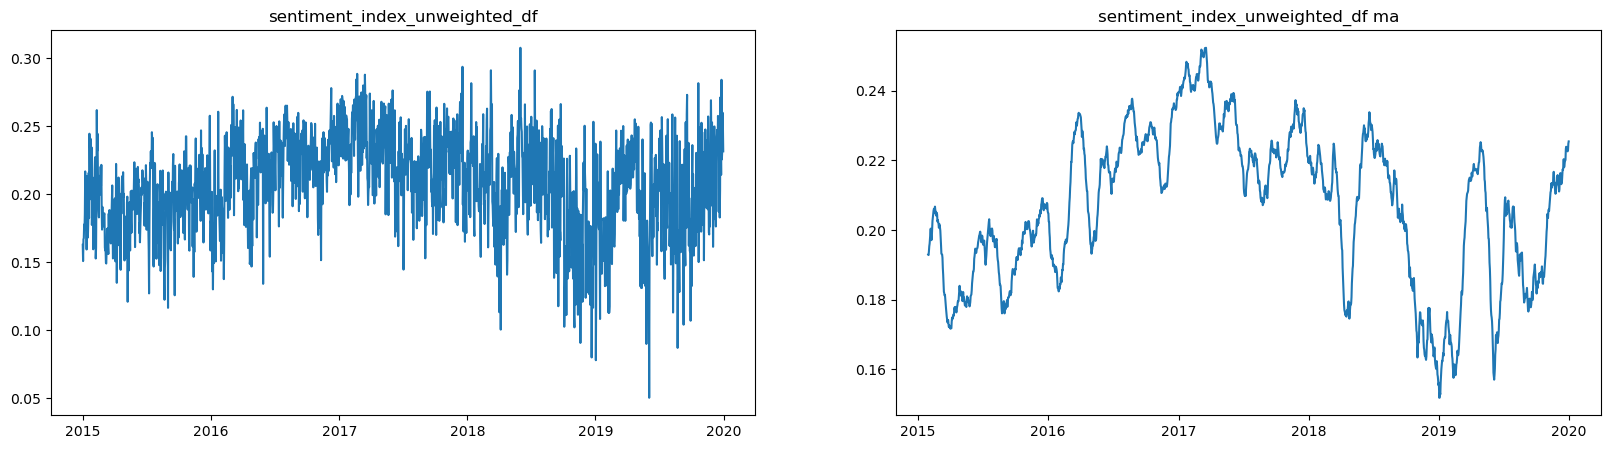

In [66]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(sentiment_index_unweighted_df['date'],sentiment_index_unweighted_df['sentiment_score'])
plt.title('sentiment_index_unweighted_df')
plt.subplot(1, 2, 2)
plt.plot(sentiment_index_unweighted_df['date'],sentiment_index_unweighted_df['moving_average'])
plt.title('sentiment_index_unweighted_df ma')
plt.show()

## Save index to xlsx file

In [67]:
# Save index to xlsx
sentiment_index_unweighted_path = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted.xlsx"

sentiment_index_unweighted_df.to_excel(sentiment_index_unweighted_path, index=False)
